## 2.3.8 커널 서포트 벡터 머신


### 선형 모델과 비선형 특성

선형 모델을 유연하게 만드는 한 가지 방법은 특성끼리 곱하거나 특성을 거듭제곱하는 식으로 새로운 특성을 추가하는 것입니다.

In [5]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import mglearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

In [11]:
from matplotlib import font_manager
import matplotlib
font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
matplotlib.rcParams['axes.unicode_minus'] = False
print(font_family)

Malgun Gothic


In [8]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_fname = 'C:/Windows/Fonts/malgun.ttf'

font_family = font_manager.FontProperties(fname=font_fname).get_name()

plt.rcParams["font.family"] = font_family

Text(0, 0.5, '특성 1')

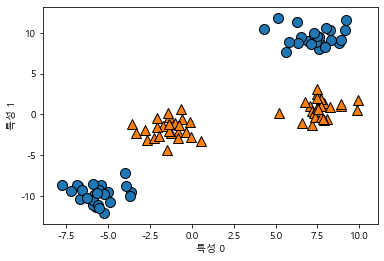

In [12]:
X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

Text(0, 0.5, '특성 1')

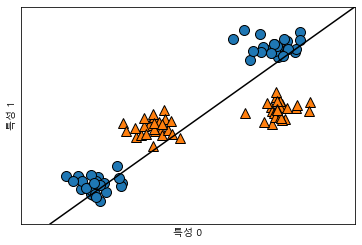

In [13]:
from sklearn.svm import LinearSVC

linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

분류를 위한 선형 모델은 직선으로만 데이터 포인트를 나눌 수 있어서 이런 데이터셋에는 잘 들어 맞지 않습니다.
두 번째 특성을 제곱한 특성1 ** 2를 새로운 특성으로 추가해 입력 특성을 확장해서 3차원 산점도로 나타내보겠습니다.

Text(0.5, 0, '특성1 ** 2')

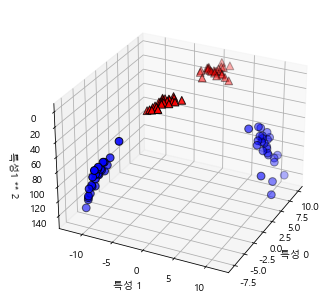

In [16]:
# 두 번째 특성을 제곱하여 추가합니다.
X_new = np.hstack([X, X[:, 1:] ** 2])
from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()

# 3차원 그래프
ax = Axes3D(figure, elev=-152, azim=-26)

# y == 0 인 포인트를 먼저 그리고 그 다음 y == 1인 포인트를 그립니다.
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel("특성 0")
ax.set_ylabel("특성 1")
ax.set_zlabel("특성1 ** 2")

Text(0.5, 0, '특성1 ** 2')

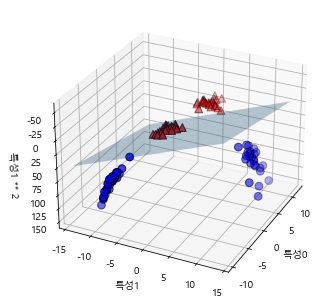

In [21]:
linear_svm_3d = LinearSVC(max_iter=5000).fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# 선형 결정 경계 그리기
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')

ax.set_xlabel("특성0")
ax.set_ylabel("특성1")
ax.set_zlabel("특성1 ** 2")

위의 그림은 확장된 3차원 데이터셋에서 선형 SVM이 만든 결정 경계입니다.

Text(0, 0.5, '특성 1')

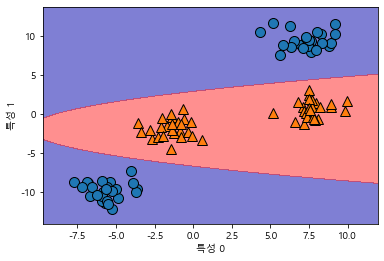

In [23]:
ZZ = YY ** 2

dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()], cmap=mglearn.cm2, alpha=0.5)

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

### 커널 기법

커널기법은 실제로 데이터를 확장하지 않고 확장된 특성에 대한 데이터 포인트들의 거리를 계산합니다.

서포트 벡터 머신에서 데이터를 고차원 공간에 매핑하는 데 많이 사용하는 방법은 두 가지입니다.

1. 원래 특성의 가능한 조합을 지정된 차수까지 모두 계산하는 다항식 커널
2. 모든 차수의 모든 다항식을 고려하는 가우시안 터널


### SVM 이해하기

두 클래스 사이의 경계에 위치한 데이터 포인트를 서포트 벡터라 합니다. 새로운 데이터 포인트에 대해 예측하려면 각 서포트 벡터와의 거리를 측정합니다. 분류 셜정은 서포트 벡터까지의 거리에 기반하며 서포트 벡터의 중요도는 훈련 과정에서 학습합니다.

Text(0, 0.5, '특성 1')

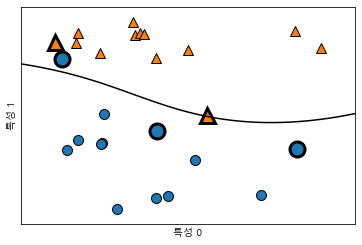

In [26]:
from sklearn.svm import SVC

X, y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)
mglearn.plots.plot_2d_separator(svm, X, eps=.5)

# 데이터 포인트 그리기
mglearn.discrete_scatter(X[:,0], X[:, 1], y)

# 서포트 벡터
sv = svm.support_vectors_

# dual_coef_의 부호에 의해 서포트 벡터의 클래스 레이블이 결정됩니다.
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

### SVM 매개변수 튜닝

1. gamma 매개변수는 하나의 훈련 샘플이 미치는 영향의 범위를 결정한다.
2. C 매개변수는 선형 모델에서 사용한 것과 비슷한 규제 매개변수입니다.

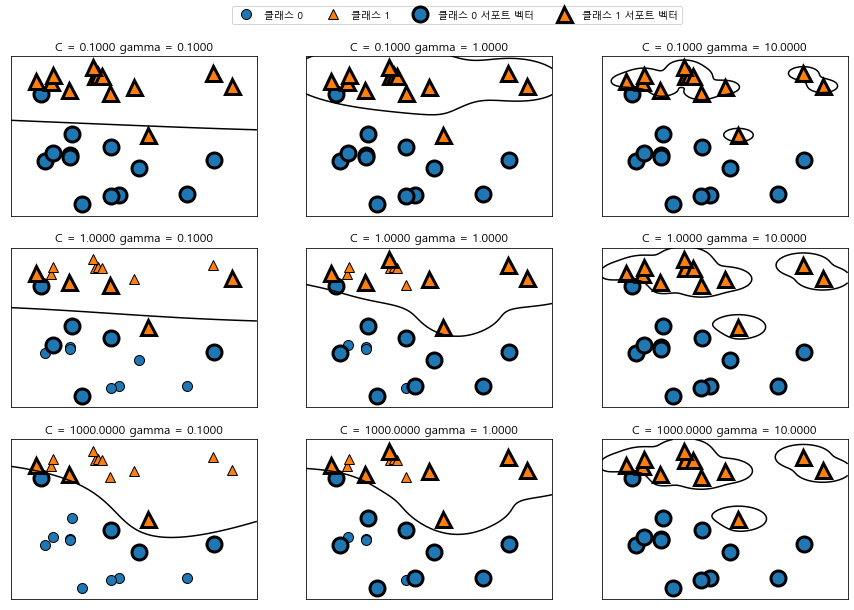

In [31]:
# 매개 변수를 다르게 했을 때 어떻게 변경되는지 확인

fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)
        
axes[0, 0].legend(["클래스 0", "클래스 1", "클래스 0 서포트 벡터", "클래스 1 서포트 벡터"],
                  ncol=4, loc=(.9, 1.2))

C 를 증가시키면 이 포인트들이 모델에 큰 영향을 주며 결정 경계를 휘어서 정확하게 분류합니다.

훈련 세트 정확도 : 0.90
테스트 세트 정확도 : 0.94


Text(0, 0.5, '특성 크기')

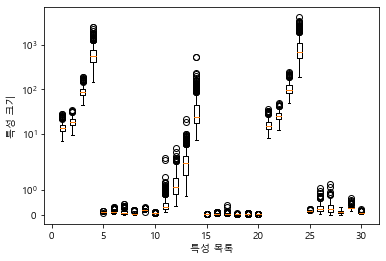

In [37]:
# SVM을 유방암 데이터셋에 적용
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(
    cancer['data'], cancer['target'], random_state=0)

svc = SVC()
svc.fit(X_train, y_train)

print("훈련 세트 정확도 : {:.2f}".format(svc.score(X_train, y_train)))
print("테스트 세트 정확도 : {:.2f}".format(svc.score(X_test, y_test)))

plt.boxplot(X_train, manage_ticks=False)
plt.yscale("symlog")
plt.xlabel("특성 목록")
plt.ylabel("특성 크기")

### SVM을 위한 데이터 전처리

커널 SVM에서는 모든 특성 값을 평균이 0이고 단위 분산이 되도록 하거나, 0과 1 사이로 맞추는 방법을 많이 사용합니다. 

In [42]:
# 훈련 세트에서 특성별 최솟값 계산
min_on_training = X_train.min(axis=0)

# 훈련 세트에서 특성별 (최댓값 - 최솟값) 범위 계산
range_on_training = (X_train - min_on_training).max(axis=0)

# 훈련 데이터에 최솟값을 빼고 범위로 나누면
# 각 특성에 대해 최솟값은 0 최댓값은 1입니다.

X_train_scaled = (X_train - min_on_training) / range_on_training
print("특성별 최솟값\n", X_train_scaled.min(axis=0))
print("특성별 최댓값\n", X_train_scaled.max(axis=0))
print("=============================================================")
print("=============================================================")

# 테스트 세트에도 같은 작업을 적용하지만
# 훈련 세트에서 계산한 최솟값과 범위를 사용합니다
X_test_scaled = (X_test - min_on_training) / range_on_training

svc = SVC()
svc.fit(X_train_scaled, y_train)

print("훈련 세트 정확도 : {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("테스트 세트 정확도 : {:.3f}".format(svc.score(X_test_scaled, y_test)))

특성별 최솟값
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
특성별 최댓값
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
훈련 세트 정확도 : 0.984
테스트 세트 정확도 : 0.972


In [52]:
# C 값을 증가시켜보았다.

svc = SVC(C=52)
svc.fit(X_train_scaled, y_train)

print("훈련 세트 정확도 : {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("테스트 세트 정확도 : {:.3f}".format(svc.score(X_test_scaled, y_test)))

훈련 세트 정확도 : 0.995
테스트 세트 정확도 : 0.979


### 장단점과 매개변수

SVM은 데이터의 특성이 몇 개 안되더라도 복잡한 결정 경계를 만들 수 있습니다. 하지만 샘플이 많을 때는 잘 맞지 않습니다.

또 다른 단점은 데이터 전처리와 매개변수 설정에 신경을 많이 써야 한다는 점입니다.

## 2.3.9 신경망(딥러닝)

### 신경망 모델
다층 퍼셉트론(MLP)는 여러 단계를 거쳐 결정을 만들어내는 선형 모델의 일반화된 모습이라고 볼 수 있습니다.

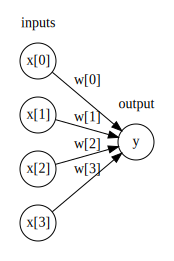

In [53]:
# 로지스틱 회귀
display(mglearn.plots.plot_logistic_regression_graph())

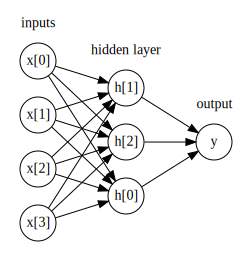

In [56]:
# 은닉층이 하나인 다층 퍼셉츠론
display(mglearn.plots.plot_single_hidden_layer_graph())

이런 모델은 많은 계수를 학습해야 합니다.

이 모델을 선형 모델보다 강력하게 만들려면 각 은닉 유닛의 가중치 합을 계산한 후 그 결과에 비선형 함수인 렐루와 하이퍼볼릭 탄젠트를 적용해야 합니다.

Text(0, 0.5, 'relu(x), tanh(x)')

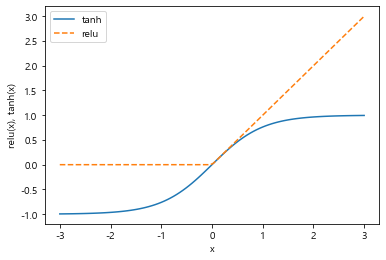

In [57]:
# 하이퍼볼릭 탄젠트 활성화 함수와 렐루 활성화 함수

line = np.linspace(-3, 3, 100)
plt.plot(line, np.tanh(line), label="tanh")
plt.plot(line, np.maximum(line, 0), linestyle='--', label="relu")
plt.legend(loc="best")
plt.xlabel("x")
plt.ylabel("relu(x), tanh(x)")

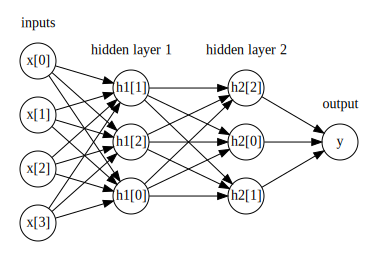

In [58]:
# 은닉층이 두개인 다층 퍼셉트론

mglearn.plots.plot_two_hidden_layer_graph()

### 신경망 튜닝

Text(0, 0.5, '특성 1')

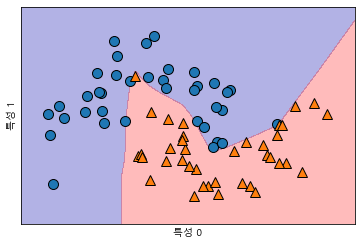

In [60]:
# 은닉 유닛이 100개인 신경망으로 학습시킨 two_moons 데이터셋의 결정 경계

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

mlp = MLPClassifier(solver='lbfgs', random_state=0).fit(X_train, y_train)
mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
mglearn.discrete_scatter(X_train[:, 0] , X_train[:, 1], y_train)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

Text(0, 0.5, '특성 1')

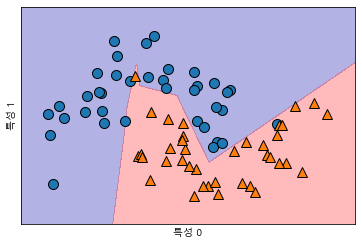

In [61]:
#  히든레이어를 10개로 줄임

mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[10]).fit(X_train, y_train)
mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
mglearn.discrete_scatter(X_train[:, 0] , X_train[:, 1], y_train)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

Text(0, 0.5, '특성 1')

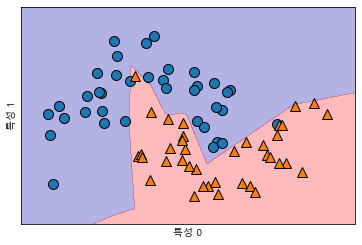

In [62]:
# 10개의 유닛으로 된 두 개의 은닉층

mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[10, 10]).fit(X_train, y_train)
mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
mglearn.discrete_scatter(X_train[:, 0] , X_train[:, 1], y_train)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

Text(0, 0.5, '특성 1')

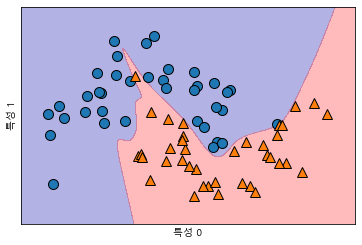

In [63]:
# tanh 활성화 함수가 적용된 10개의 유닛으로 된 두 개의 은닉층

mlp = MLPClassifier(solver='lbfgs', activation='tanh', random_state=0,
                    hidden_layer_sizes=[10, 10]).fit(X_train, y_train)
mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
mglearn.discrete_scatter(X_train[:, 0] , X_train[:, 1], y_train)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

two_moons 데이터셋에 유닛이 각각 10개와 100개인 은닉층 2개를 사용했을 때 다른 alpha 값이 미치는 영향

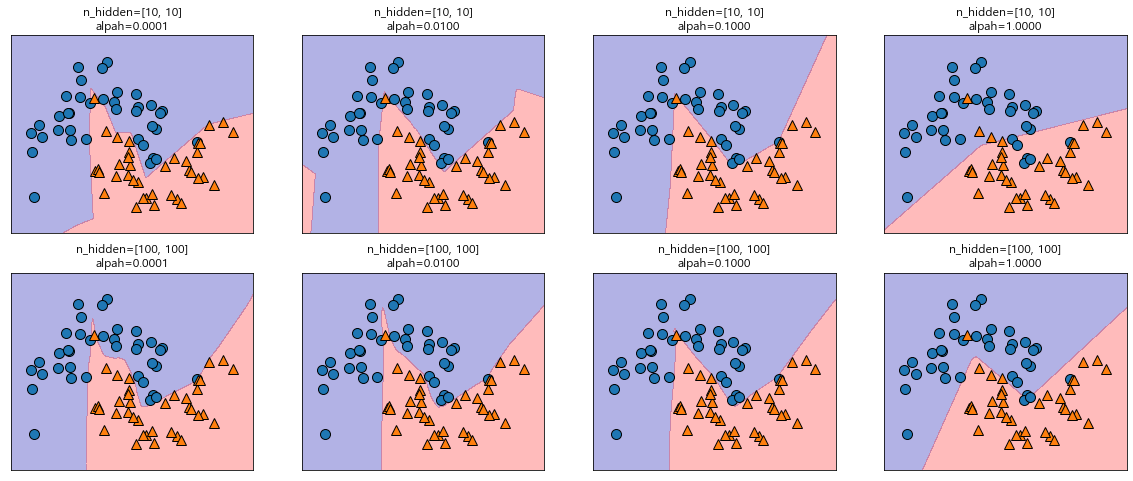

In [66]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
for axx, n_hidden_nodes in zip(axes, [10, 100]):
    for ax, alpha in zip(axx, [0.0001, 0.01, 0.1, 1]):
        mlp = MLPClassifier(solver='lbfgs', random_state=0,
                            hidden_layer_sizes=[n_hidden_nodes, n_hidden_nodes], alpha=alpha)
        mlp.fit(X_train, y_train)
        mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3, ax=ax)
        mglearn.discrete_scatter(X_train[:, 0] , X_train[:, 1], y_train, ax=ax)
        ax.set_title("n_hidden=[{}, {}]\nalpah={:.4f}".format(n_hidden_nodes, n_hidden_nodes, alpha))

밑은 위와 같은 매개변수를 가졌지만 초기화를 다르게 하여 만든 모델입니다.

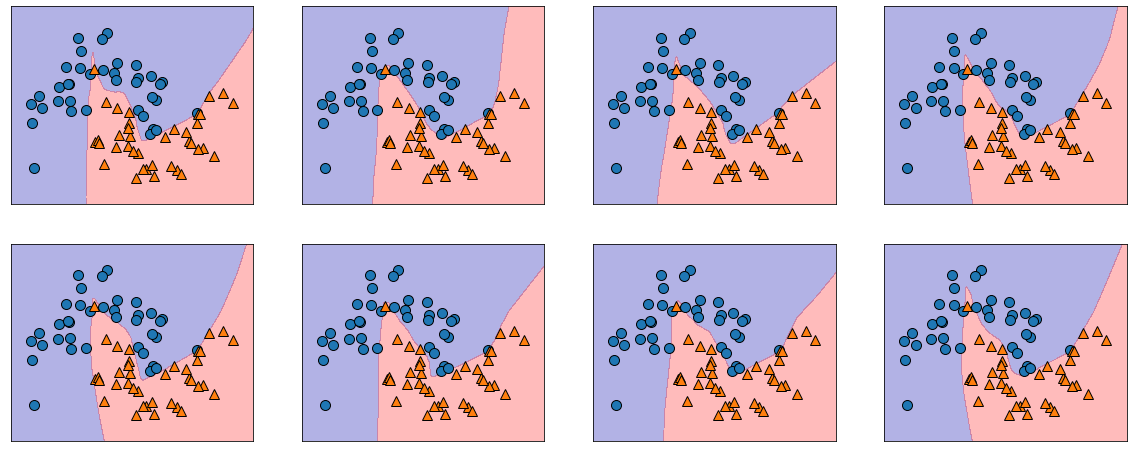

In [69]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
for i, ax in enumerate(axes.ravel()):
        mlp = MLPClassifier(solver='lbfgs', random_state=i,
                            hidden_layer_sizes=[100, 100])
        mlp.fit(X_train, y_train)
        mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3, ax=ax)
        mglearn.discrete_scatter(X_train[:, 0] , X_train[:, 1], y_train, ax=ax)

유방암 데이터셋에 MLPClassifier를 적용해보겠습니다.

In [73]:
print("유방암 데이터의 특성별 최댓값:\n", cancer.data.max(axis=0))
print("================================================================")
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

mlp = MLPClassifier(random_state=42)
mlp.fit(X_train, y_train)

print("훈련 세트 정확도: {:.2f}".format(mlp.score(X_train, y_train)))
print("테스트 세트 정확도: {:.2f}".format(mlp.score(X_test, y_test)))

유방암 데이터의 특성별 최댓값:
 [2.811e+01 3.928e+01 1.885e+02 2.501e+03 1.634e-01 3.454e-01 4.268e-01
 2.012e-01 3.040e-01 9.744e-02 2.873e+00 4.885e+00 2.198e+01 5.422e+02
 3.113e-02 1.354e-01 3.960e-01 5.279e-02 7.895e-02 2.984e-02 3.604e+01
 4.954e+01 2.512e+02 4.254e+03 2.226e-01 1.058e+00 1.252e+00 2.910e-01
 6.638e-01 2.075e-01]
훈련 세트 정확도: 0.94
테스트 세트 정확도: 0.92


MLP의 정확도는 꽤 높지만 다른 모델만큼은 아닙니다. 입력 특성을 평균은 0, 분산은 1이 되도록 데이터의 스케일을 맞춰서 변형해보겠습니다.

In [77]:
# 훈련 세트 각 특성의 평균을 계산합니다.
mean_on_train = X_train.mean(axis=0)
# 훈련 세트 각 특성의 표준 편차를 계산합니다
std_on_train = X_train.std(axis=0)

# 데이터에서 평균을 빼고 표준 편차로 나누면
# 평균 0, 표준 편차 1인 데이터로 변환됩니다.
X_train_scaled = (X_train - mean_on_train) / std_on_train
# (훈련 데이터의 평균과 표준 편차를 이용해) 같은 변환을 테스트 세트에도 합니다
X_test_scaled = (X_test - mean_on_train) / std_on_train

mlp = MLPClassifier(random_state=0)
mlp.fit(X_train_scaled, y_train)

print("훈련 세트 정확도: {:.3f}".format(mlp.score(X_train_scaled, y_train)))
print("테스트 세트 정확도: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

훈련 세트 정확도: 0.991
테스트 세트 정확도: 0.965


In [79]:
# 반복 횟수를 늘려서 실행

mlp = MLPClassifier(max_iter=1000, random_state=0)
mlp.fit(X_train_scaled, y_train)

print("훈련 세트 정확도: {:.3f}".format(mlp.score(X_train_scaled, y_train)))
print("테스트 세트 정확도: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.972


In [80]:
# alpha매개변수를 0.0001에서 1로 증가

mlp = MLPClassifier(max_iter=1000, alpha=1, random_state=0)
mlp.fit(X_train_scaled, y_train)

print("훈련 세트 정확도: {:.3f}".format(mlp.score(X_train_scaled, y_train)))
print("테스트 세트 정확도: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

훈련 세트 정확도: 0.988
테스트 세트 정확도: 0.972


유방암 데이터셋으로 학습시킨 신경망의 첫 번째 층의 가중치 히트맵입니다.

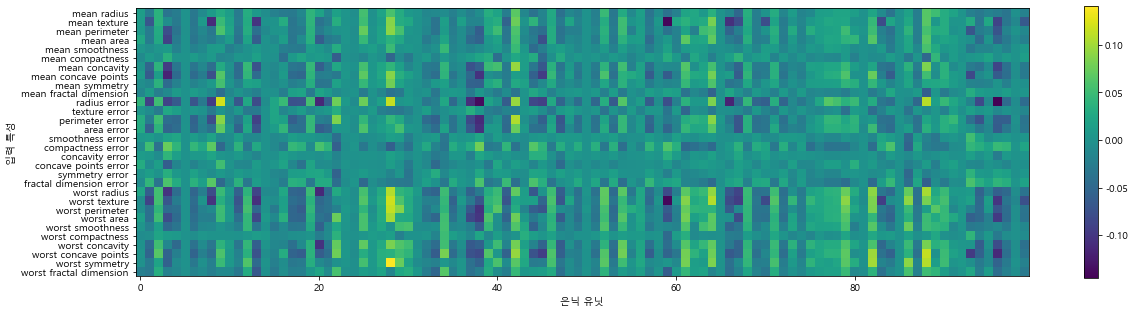

In [81]:
plt.figure(figsize=(20, 5))
plt.imshow(mlp.coefs_[0], interpolation='none', cmap='viridis')
plt.yticks(range(30), cancer.feature_names)
plt.xlabel("은닉 유닛")
plt.ylabel("입력 특성")
plt.colorbar()

### 장단점과 매개변수

충분한 연산시간과 데이터를 주고 매개변수를 세심하게 조정하면 신경망은 종종  다른 머신러닝 알고리즘을 뛰어넘는 성능을 냅니다.

그러나 단점으로 학습이 오래 걸리고 데이터 전처리에 주의해야합니다. 

### 신경망의 복잡도 추정

신경망에서 가장 중요한 매개변수
1. 은닉층의 개수
2. 각 은닉층의 유닛 수

신경망에 모델 복잡도에 관해 도움이 될 만한 측정치는 학습된 가중치 또는 계수의 수입니다.
신경망의 매개변수를 조정하는 일반적인 방법은 먼저 충분히 과대적합되어서 문제를 해결할만한 큰 모델을 만들고 데이터가 충분히 학습될 수 있다고 생각될 때 구조를 줄이거나 alpha 값을 증가시켜 일반화 성능을 향상시킵니다.

solver 매개변수에서 기본값은 adam으로 데이터의 스케일에 조금 민감해서 스케일링 하는게 중요하다. 다른 하나는lbfgs로 안정적이지만 규모가 큰 모델이나 대량의 데이터셋에는 시간이 오래 걸립니다. sgd는 다른 여러 매개변수와 함께 튜닝하여 최선의 결과를 만들 수 있습니다.

## 2.4 분류 예측의 불확실성 추정

scikit-learn 분류기에서 불확실성을 추정할 수 있는 함수가 두개 있습니다.
1. decision_function
2. predict_proba

In [88]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_circles

# 예제를 위해 클래스의 이름을 "blue"와 "red"로 바꿉니다.
y_named = np.array(["blue", "red"])[y]

# 여러 개의 배열을 한꺼번에 train_test_split에 넣을 수 있습니다.
# 훈련 세트와 테스트 세트로 나뉘는 방식은 모두 같습니다.
X_train, X_test, y_train_named, y_test_named, y_train, y_test = \
    train_test_split(X, y_named, y, random_state=0)

# 그레이디언트 부스팅 모델을 만듭니다.
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train_named)

GradientBoostingClassifier(random_state=0)

## 2.4.1 결정 함수

이진 분류에서 decision_function 반환값의 크기는 (n_samples,)이며 각 샘플이 하나의 실수 값을 반환합니다.

In [90]:
print("X_test.shape:", X_test.shape)
print("결정 함수 결과 형태:", gbrt.decision_function(X_test).shape)

X_test.shape: (25, 2)
결정 함수 결과 형태: (25,)


In [91]:
# 결정 함수 결과 중 앞부분 일부를 확인합니다.
print("결정 함수:\n", gbrt.decision_function(X_test)[:6])

결정 함수:
 [ 4.13592603 -1.70169917 -3.95106099 -3.62609552  4.28986642  3.66166081]


In [92]:
print("임계치와 결정 함수 결과 비교:\n", gbrt.decision_function(X_test) > 0)
print("예측 :\n", gbrt.predict(X_test))

임계치와 결정 함수 결과 비교:
 [ True False False False  True  True False  True  True  True False  True
  True False  True False False False  True  True  True  True  True False
 False]
예측 :
 ['red' 'blue' 'blue' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red' 'blue'
 'red' 'red' 'blue' 'red' 'blue' 'blue' 'blue' 'red' 'red' 'red' 'red'
 'red' 'blue' 'blue']


In [93]:
# 불리언 값을 0과 1로 변환합니다
greater_zero = (gbrt.decision_function(X_test) > 0).astype(int)
# classes_에 인덱스로 사용합니다.
pred = gbrt.classes_[greater_zero]
# pred 와 gbrt.predict의 결과를 비교합니다.
print("pred는 예측 결과와 같다:", np.all(pred == gbrt.predict(X_test)))

pred는 예측 결과와 같다: True


In [94]:
decision_function = gbrt.decision_function(X_test)
print("결정 함수 최솟값: {:.2f} 최댓값: {:.2f}".format(np.min(decision_function), np.max(decision_function)))

결정 함수 최솟값: -7.69 최댓값: 4.29


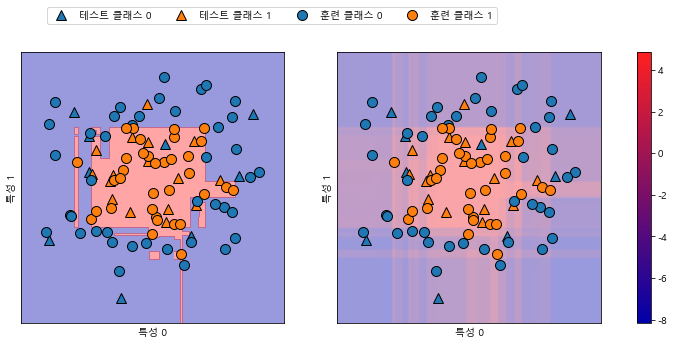

In [101]:
# 결정 경계와 함께 decision_function을 그래프로 표현하기

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1], alpha=.4, cm=mglearn.ReBl)

for ax in axes:
    # 훈련 포인트와 테스트 포인트 그리기
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, markers='o', ax=ax)    
    ax.set_xlabel("특성 0")
    ax.set_ylabel("특성 1")
    
cbar = plt.colorbar(scores_image, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(["테스트 클래스 0", "테스트 클래스 1", "훈련 클래스 0", "훈련 클래스 1"], ncol=4, loc=(.1, 1.1))

## 2.4.2 예측 확률

predict_proba의 출력은 각 클래스에 대한 확률이고 decision_function의 출력보다 이해하기 더 쉽습니다. 이 값의 크기는 이진 분류에서는 항상(n_samples, 2) 입니다.

In [102]:
print("확률 값의 형태:", gbrt.predict_proba(X_test).shape)

확률 값의 형태: (25, 2)


In [104]:
# predict_proba 결과 중 앞부분 일부를 확인합니다.
print("Predicted probabilities:\n",
      gbrt.predict_proba(X_test[:6]))

Predicted probabilities:
 [[0.01573626 0.98426374]
 [0.84575653 0.15424347]
 [0.98112869 0.01887131]
 [0.97407033 0.02592967]
 [0.01352142 0.98647858]
 [0.02504637 0.97495363]]


각 행의 첫 번째 원소는 첫 번째 클래스의 예측 확률이고 두 번째 원소는 두 번째 클래스의 예측 확률입니다.

일반적으로 과대적합된 모델은 잘못된 예측이더라도 예측의 확신이 강하고 복잡도가 낮은 모델은 예측에 불확실성이 더 많습니다.

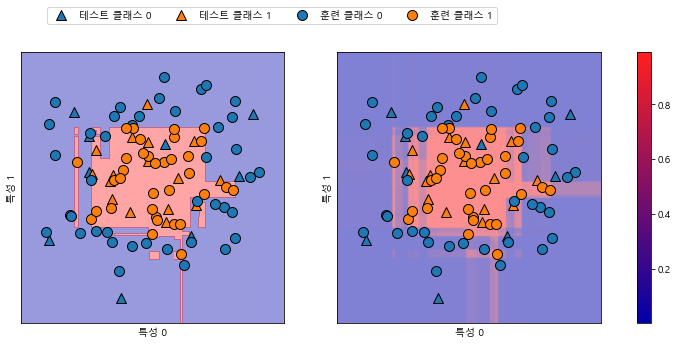

In [108]:
# 결정 경계와 클래스 1의 확률을 그려보자

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1], alpha=.5, cm=mglearn.ReBl, function='predict_proba')

for ax in axes:
    # 훈련 포인트와 테스트 포인트를 그리기
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, markers='o', ax=ax)
    ax.set_xlabel("특성 0")
    ax.set_ylabel("특성 1")    
    
# colorbar 를 감추지 않습니다.
cbar = plt.colorbar(scores_image, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(["테스트 클래스 0", "테스트 클래스 1", "훈련 클래스 0", "훈련 클래스 1"], ncol=4, loc=(.1, 1.1))

## 2.4.3 다중 분류에서의 불확실성

In [109]:
# 클래스가 세 개인 iris 데이터셋

from sklearn.datasets import load_iris

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=42)

gbrt = GradientBoostingClassifier(learning_rate=0.01, random_state=0)
gbrt.fit(X_train, y_train)

print("결정 함수의 결과 형태:", gbrt.decision_function(X_test).shape)
# 앞부분만 확인
print("결정 함수의 결과:\n", gbrt.decision_function(X_test)[:6, :])

결정 함수의 결과 형태: (38, 3)
결정 함수의 결과:
 [[-1.995715    0.04758267 -1.92720695]
 [ 0.06146394 -1.90755736 -1.92793758]
 [-1.99058203 -1.87637861  0.09686725]
 [-1.995715    0.04758267 -1.92720695]
 [-1.99730159 -0.13469108 -1.20341483]
 [ 0.06146394 -1.90755736 -1.92793758]]


In [110]:
print("가장 큰 결정 함수의 인덱스:\n", np.argmax(gbrt.decision_function(X_test), axis=1))
print("예측:\n", gbrt.predict(X_test))

가장 큰 결정 함수의 인덱스:
 [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
예측:
 [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


In [111]:
# predict_proba 결과 중 앞부분 일부를 확인합니다.
print("예측 확률:\n", gbrt.predict_proba(X_test[:6]))

# 행방향으로 확률을 더하면 1이 됩니다.
print("합:", gbrt.predict_proba(X_test)[:6].sum(axis=1))

예측 확률:
 [[0.10217718 0.78840034 0.10942248]
 [0.78347147 0.10936745 0.10716108]
 [0.09818072 0.11005864 0.79176065]
 [0.10217718 0.78840034 0.10942248]
 [0.10360005 0.66723901 0.22916094]
 [0.78347147 0.10936745 0.10716108]]
합: [1. 1. 1. 1. 1. 1.]


In [112]:
print("가장 큰 예측 확률의 인덱스:\n",
      np.argmax(gbrt.predict_proba(X_test), axis=1))
print("예측:\n", gbrt.predict(X_test))

가장 큰 예측 확률의 인덱스:
 [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
예측:
 [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


In [117]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)

# iris 데이터셋의 타깃을 클래스 이름으로 나타내기
named_target = iris.target_names[y_train]
logreg.fit(X_train, named_target)
print("훈련 데이터에 있는 클래스 종류:", logreg.classes_)
print("예측:", logreg.predict(X_test)[:10])
argmax_dec_func = np.argmax(logreg.decision_function(X_test), axis=1)
print("가장 큰 결정 함수의 인덱스:", argmax_dec_func[:10])
print("인덱스를 classes_에 연결:", logreg.classes_[argmax_dec_func][:10])

훈련 데이터에 있는 클래스 종류: ['setosa' 'versicolor' 'virginica']
예측: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']
가장 큰 결정 함수의 인덱스: [1 0 2 1 1 0 1 2 1 1]
인덱스를 classes_에 연결: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']


## 2.5 요약 및 정리

#### 최근접 이웃
작은 데이터셋일 경우, 기본 모델로서 좋고 설명하기 쉬움

#### 선형 모델
첫 번째로 시도할 알고리즘. 대용량 데이터셋 가능. 고차원 데이터에 가능

#### 나이브 베이즈
분류만 가능. 선형 모델보다 훨씬 빠름. 대용량 데이터셋과 고차원 데이터에 가능. 선형 모델보다 덜 정확함

#### 결정트리
매우 빠름. 데이터 스케일 조정이 필요 없음. 시각화하기 좋고 설명하기 쉬움

#### 랜덤 포레스트
결정 트리 하나보다 거의 항상 좋은 성능을 냄. 매우 안정적이고 강력함. 데이터 스케일 조정 필요 없음. 고차원 희소 데이터에는 잘 안 맞음

#### 그레이디언트 부스팅 결정 트리
랜덤 포레스트보다 조금 더 성능이 좋음. 랜덤 포레스트보다 학습은 느리나 예측은 빠르고 메모리를 조금 사용. 랜덤 포레스트보다 매개변수 튜닝이 많이 필요함

#### 서포트 벡터 머신
비슷한 의미의 특성으로 이뤄진 중간 규모 데이터셋에 잘 맞음. 데이터 스케일 조정 필요. 매개변수에 민감

#### 신경망
특별히 대용량 데이터셋에서 매우 복잡한 모델을 만들수 있음. 매개변수 선택과 데이터 스케일에 민감. 큰 모델은 학습이 좀 오래걸림


새로운 데이터셋으로 작업할 때
1. 선형 모델, 나이브 베이즈, 최근접 이웃 분류기로 시작해서 성능 가늠
2. 데이터를 충분히 이해한 후 랜덤 포레스트와 같은 복잡한 모델을 만들 수 있는 알고리즘 고려